<a href="https://colab.research.google.com/github/JangJiYeon12/Kaggle_ICR_Competition/blob/main/ICR_Simple_EDA_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path.append('/usr/local/lib/')

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '../input/iterativestratification',
 '../input/iterativestratification']

In [ ]:
!pip install iterative-stratification==0.1.6
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, kurtosis
import warnings

from sklearn.preprocessing import LabelEncoder
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from tqdm.auto import tqdm
import catboost as cb


from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
cust_color = [
    '#EDC7B7',
    '#EEE2DC',
    '#BAB2B5',
    '#123C69',
    '#AC3B61'
]
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams["axes.grid"] = False
plt.rcParams["grid.color"] = cust_color[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["font.family"] = "monospace"

plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 0.5

In [ ]:
train = pd.read_csv('/content/train.csv')
greeks = pd.read_csv('/content/greeks.csv')
test = pd.read_csv('/content/test.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [ ]:
train.head(10)

Id        AB          AF          AH         AM         AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407   8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889   8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553   8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203   8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738   8.138688   
5  04517a3c90bd  0.209377  2615.81430   85.200147   8.541526   8.138688   
6  049232ca8356  0.348249  1733.65412   85.200147   8.377385  15.312480   
7  057287f2da6d  0.269199   966.45483   85.200147  21.174189   8.138688   
8  0594b00fb30a  0.346113  3238.43674   85.200147  28.888816   8.138688   
9  05f2bc0155cd  0.324748  5188.68207   85.200147  12.968687   8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   
5  4.013127  0.025578  12.547282    1.229900  ...  0.173229   0.49706   
6  1.913544  0.025578   6.547778    1.229900  ...  4.408484   0.86130   
7  4.987617  0.025578   9.408886    1.229900  ...  6.591896   0.49706   
8  4.021986  0.025578   8.243016    3.626448  ...  4.762291   1.18262   
9  4.593392  0.025578  10.685041    1.229900  ...  0.173229   1.57151   

         FS         GB          GE            GF         GH          GI  \
0  0.094822  11.339138   72.611063   2003.810319  22.136229   69.834944   
1  0.568932   9.292698   72.611063  27981.562750  29.135430   32.131996   
2  1.198821  37.077772   88.609437  13676.957810  28.022851   35.192676   
3  0.284466  18.529584   82.416803   2094.262452  39.948656   90.493248   
4  0.121914  16.408728  146.109943   8524.370502  45.381316   36.262628   
5  1.164956  21.915512   72.611063  24177.595550  28.525186   82.527764   
6  0.467337  17.878444  192.453107   3332.467494  34.166222  100.086808   
7  0.277693  18.445866  109.693986  21371.759850  35.208102   31.424696   
8  0.067730  17.245908  147.218610   4589.611956  29.771721   54.675576   
9  0.318331  24.515421   98.929757   5563.130949  21.994831   33.300970   

          GL  Class  
0   0.120343      1  
1  21.978000      0  
2   0.196941      0  
3   0.155829      0  
4   0.096614      1  
5  21.978000      0  
6   0.065096      0  
7   0.092873      0  
8   0.073416      0  
9  21.978000      0  

[10 rows x 58 columns]

In [ ]:
train['EJ'].head(10)   #EJ혼자만 범주형이다

0    B
1    A
2    B
3    B
4    B
5    A
6    B
7    B
8    B
9    A
Name: EJ, dtype: object

In [ ]:
num_cols = train.columns.tolist()[1:-1]
cat_cols = 'EJ'
num_cols.remove(cat_cols)

In [ ]:
num_cols

['AB',
 'AF',
 'AH',
 'AM',
 'AR',
 'AX',
 'AY',
 'AZ',
 'BC',
 'BD',
 'BN',
 'BP',
 'BQ',
 'BR',
 'BZ',
 'CB',
 'CC',
 'CD',
 'CF',
 'CH',
 'CL',
 'CR',
 'CS',
 'CU',
 'CW',
 'DA',
 'DE',
 'DF',
 'DH',
 'DI',
 'DL',
 'DN',
 'DU',
 'DV',
 'DY',
 'EB',
 'EE',
 'EG',
 'EH',
 'EL',
 'EP',
 'EU',
 'FC',
 'FD',
 'FE',
 'FI',
 'FL',
 'FR',
 'FS',
 'GB',
 'GE',
 'GF',
 'GH',
 'GI',
 'GL']

In [ ]:
#표준편차가 큰 순으로 나열해서 20개 뽑기. 격차 많이나는 특성을 이용할 건가봄
features_std = train.loc[:,num_cols].apply(lambda x: np.std(x)).sort_values(
    ascending=False)
f_std = train[features_std.iloc[:20].index.tolist()]

# 왜도(분포의 비대칭도) 높은 순 20개/ 절대값으로 해서 왼쪽이나 오른쪽으로 치우친 정도에따라 정렬
with pd.option_context('mode.use_inf_as_na', True):
    features_skew = np.abs(train.loc[:,num_cols].apply(lambda x: np.abs(skew(x))).sort_values(
        ascending=False)).dropna()
skewed = train[features_skew.iloc[:20].index.tolist()]

# 첨도(확률분포의 뾰족한 정도) 높은 순 20개/ 절대값으로 해서 위쪽이나 아래쪽으로 뾰족한 정도에따라 정렬
with pd.option_context('mode.use_inf_as_na', True):
    features_kurt = np.abs(train.loc[:,num_cols].apply(lambda x: np.abs(kurtosis(x))).sort_values(
        ascending=False)).dropna()
kurt_f = train[features_kurt.iloc[:20].index.tolist()]

왜도
* 왼쪽으로 치우칠 수록 > 0
* 오른쪽으로 치우칠수록 < 0

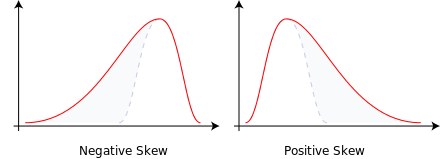

첨도
* 위로 뾰족할 수록 > 0
* 아래로 뾰족할 수록 < 0

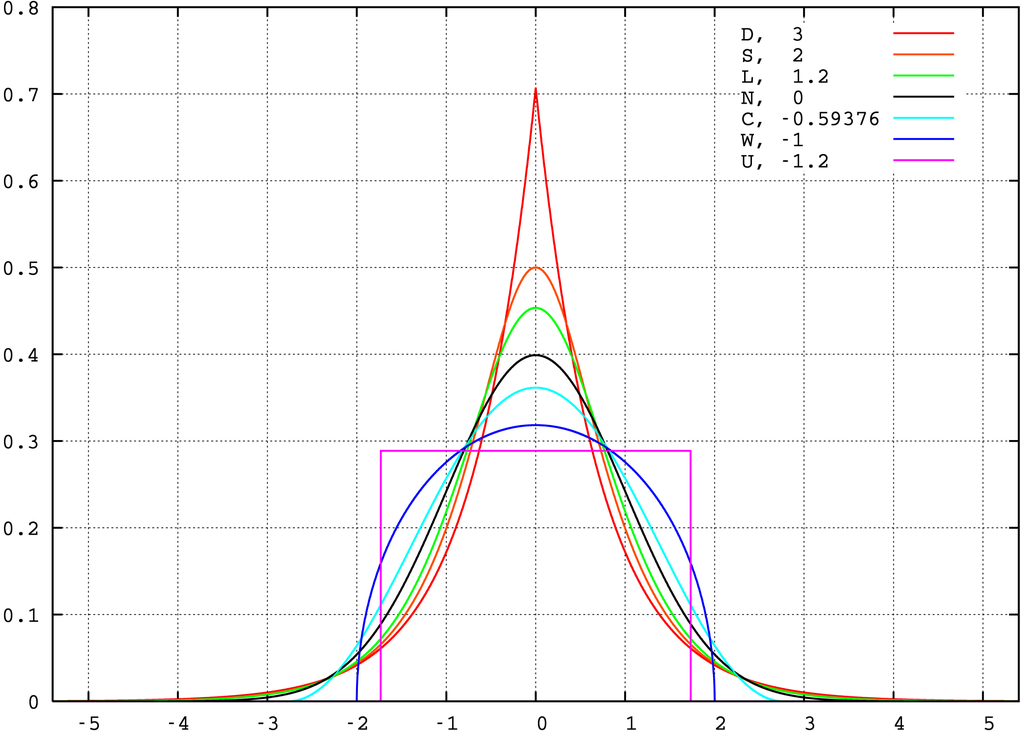

In [ ]:
features_std

GF    19337.269916
FE    11322.107755
BR     7569.152406
BD     3018.877248
AF     2298.457842
BZ     2074.687958
EG     1788.776136
EU      389.870732
DE      317.488026
BP      183.843342
FC      165.417114
CB      158.919941
GE      144.064636
AH      127.735311
BQ       96.392726
DI       86.014631
AM       69.671697
EP       68.390131
BC       65.114112
FD       64.701765
CD       51.543310
FR       50.141265
EL       38.521081
GI       36.236850
DL       28.220290
DA       21.193692
DY       18.101992
CS       17.252350
CW       14.634119
CF       13.560131
FL       11.486922
AR       10.510350
GL       10.318624
GB        9.983806
GH        9.856242
DU        9.027385
DN        8.032308
EB        6.195255
AZ        4.347118
BN        3.475458
FI        2.931647
AX        2.549627
EE        2.056675
CL        1.920651
DF        1.910833
EH        1.846001
DV        1.483351
FS        1.304303
CU        0.538280
AB        0.468009
AY        0.416479
CR        0.280967
CC        0.

In [ ]:
f_std

GF            FE           BR          BD          AF  \
0     2003.810319   9028.291921   823.928241  4126.58731  3109.03329   
1    27981.562750   6785.003474    51.216883  5496.92824   978.76416   
2    13676.957810   8338.906181   482.141594  5135.78024  2635.10654   
3     2094.262452  10965.766040   661.518640  4169.67738  3819.65177   
4     8524.370502  16198.049590  6074.859475  5728.73412  3733.04844   
..            ...           ...          ...         ...         ...   
612   8095.932828  17167.209610   365.516874  4157.68439  3130.05946   
613   3085.308063  18460.330020   505.006814  5654.07556  5462.03438   
614   6474.652866   5088.922912  2083.880500  5888.87769  2459.10720   
615   1965.343176   6464.250832   722.377629  4517.86560  1263.53524   
616   6850.484442   5895.352262   747.474930  2818.01707  2672.53426   

             BZ            EG          EU          DE          BP          FC  \
0    257.432377   1433.166750    3.828384  295.570575  175.638726   13.394640   
1    257.432377   1111.287150   52.260480  178.553100  155.868030   17.175984   
2    257.432377   1494.076488    5.390628  321.426625  128.988531  224.207424   
3    257.432377  15691.552180   31.323372  196.607985  237.282264   59.301984   
4    257.432377   1403.656300   51.141336  200.178160  324.546318   29.102640   
..          ...           ...         ...         ...         ...         ...   
612  257.432377    495.086300   65.821872  355.930925  167.877117   29.708112   
613  257.432377   1722.674025  447.657600  157.393715  285.628059   69.343680   
614  257.432377   2565.402825    3.828384  223.209115  178.661133   71.725584   
615  257.432377   1318.962875    8.259384  112.196630  119.162529   38.133312   
616  257.432377    912.311525   78.370464  889.496905  306.127863   66.893232   

            CB          GE          AH          BQ          DI          AM  \
0    47.223358   72.611063   85.200147  152.707705   89.245560   22.394407   
1    30.284345   72.611063   85.200147   14.754720  110.581815   36.968889   
2    32.563713   88.609437   85.200147  219.320160  120.056438   32.360553   
3    15.201914   82.416803  120.201618   11.050410  139.824570   77.112203   
4    82.213495  146.109943   85.200147  149.717165   97.920120   14.103738   
..         ...         ...         ...         ...         ...         ...   
612  41.368691  217.148554  123.763599   27.287375  176.977590    9.513984   
613  61.910576  496.994214   85.200147  344.644105  192.598575   46.551007   
614  90.411867  128.896894  130.138587  103.988995  218.915925   55.355778   
615  12.499760   72.611063   85.200147         NaN  113.526045   23.685856   
616  67.222974   72.611063  546.663930    6.090490  156.345390  112.006102   

             EP          BC         FD  
0     78.526968    5.555634  10.265073  
1     95.415086    1.229900   0.296850  
2     78.526968    1.229900   8.745201  
3     78.526968    1.229900   7.884336  
4     91.994825  102.151980   4.274640  
..          ...         ...        ...  
612   78.526968    2.804172   0.296850  
613  114.801199    3.777550   6.067614  
614   87.397401    1.229900   0.296850  
615   99.706633    1.229900   6.192291  
616  181.218219    7.948668   0.296850  

[617 rows x 20 columns]

In [ ]:
def feat_dist(df, cols, rows=3, columns=3, title=None, figsize=(30, 25)):

    fig, axes = plt.subplots(rows, columns, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    for i, j in zip(cols, axes):
        sns.kdeplot(df, x=i, ax=j, hue='Class', linewidth=1.5, linestyle='--')

        (mu, sigma) = norm.fit(df[i])

        xmin, xmax = j.get_xlim()[0], j.get_xlim()[1]
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, sigma)
        j.plot(x, p, 'k', linewidth=2)

        j.set_title('Dist of {0} Norm Fit: $\mu=${1:.2g}, $\sigma=${2:.2f}'.format(i, mu, sigma), weight='bold')
        j.legend(labels=[f'Class0_{i}', f'Class1_{i}', 'Normal Dist'])
        fig.suptitle(f'{title}', fontsize=24, weight='bold')

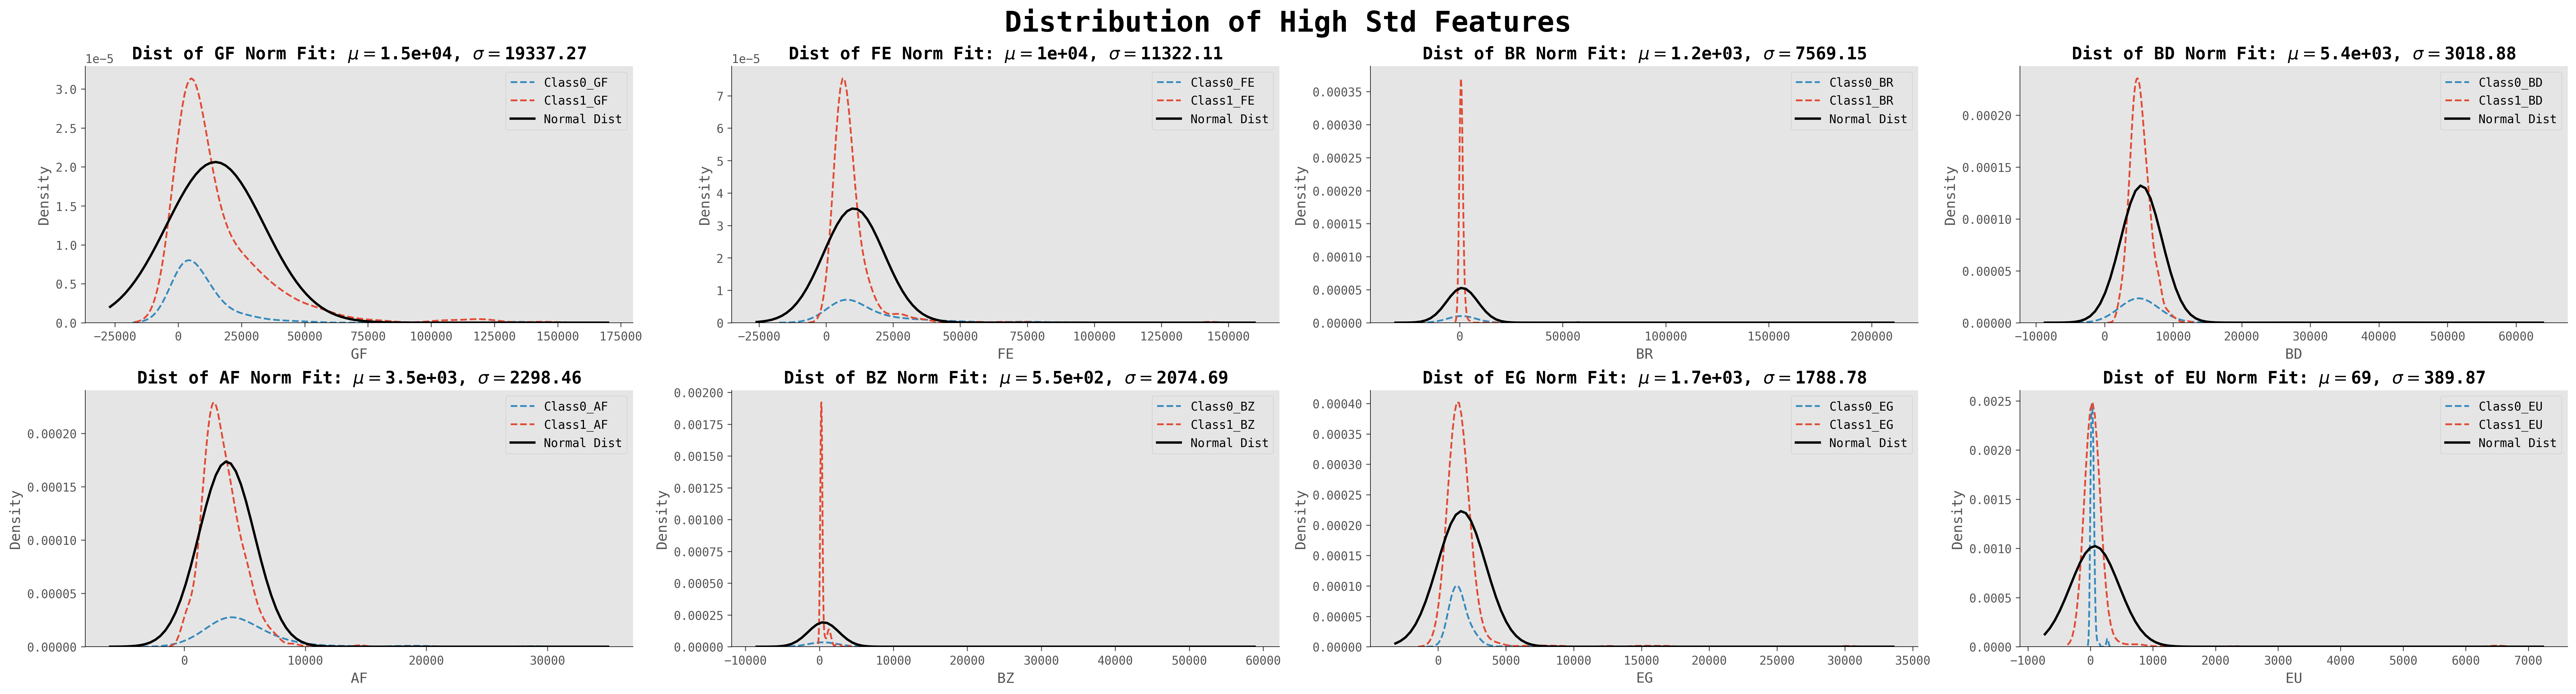

In [ ]:
feat_dist(train, f_std.columns.tolist(), rows=2, columns=4, title='Distribution of High Std Features', figsize=(30, 8))

격차로 뽑은 f_std를 이용해서 그래프를 그려보면 class 0과 class 1의 분포가 아주 많은 차이를 보인다는 것을 알 수 있다.

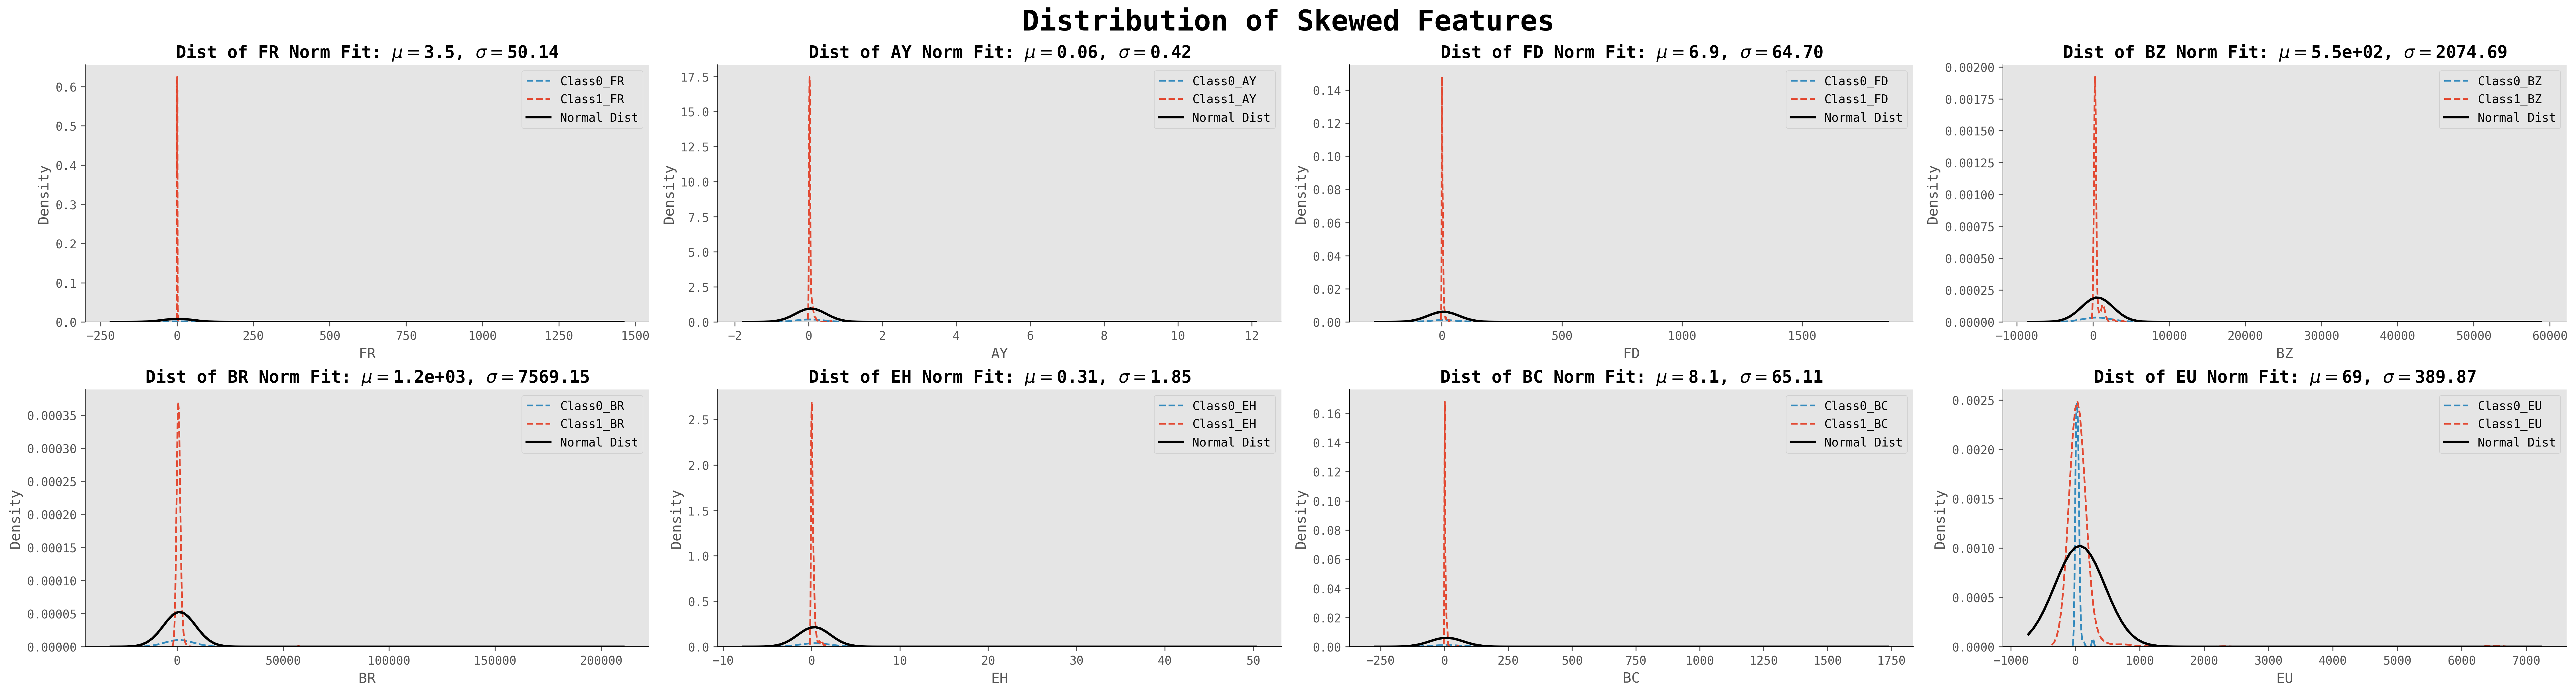

In [ ]:
feat_dist(train, skewed.columns.tolist(), rows=2, columns=4, title='Distribution of Skewed Features', figsize=(30, 8))

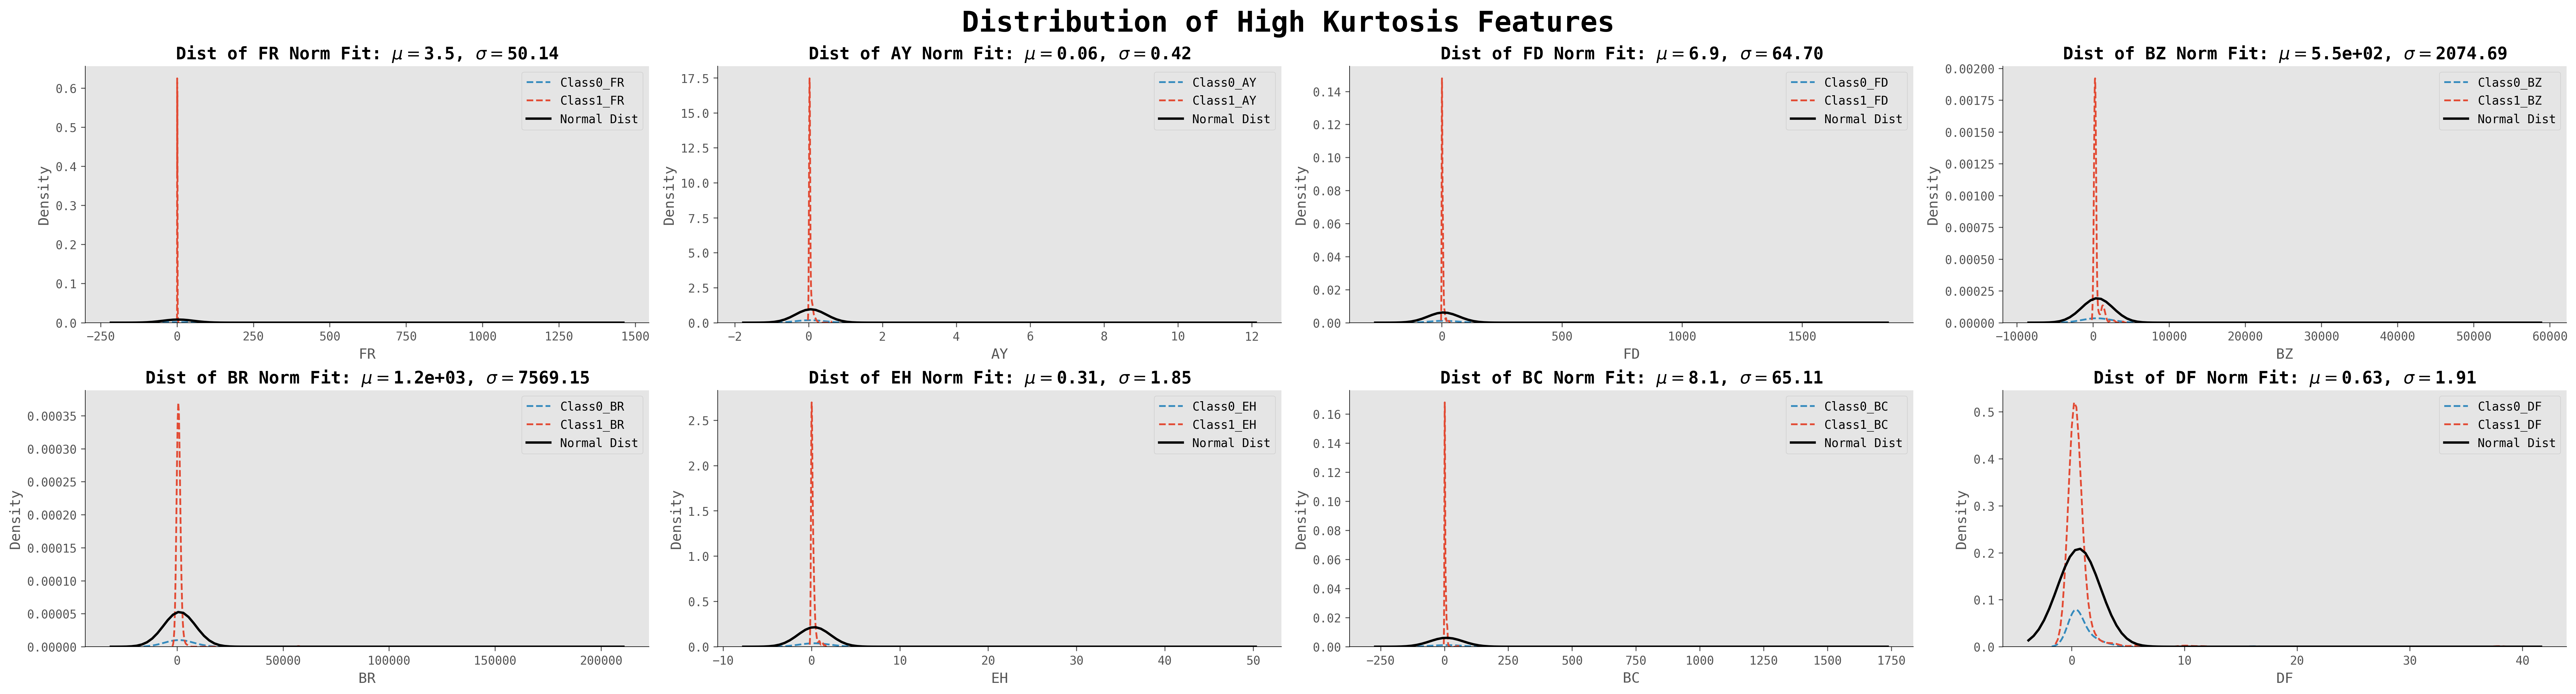

In [ ]:
feat_dist(train, kurt_f.columns.tolist(), rows=2, columns=4, title='Distribution of High Kurtosis Features', figsize=(30, 8))

왜도나 첨도를 이용한것도 마찬가지로 비슷한 패턴을 보인다는 것을 알 수 있다.

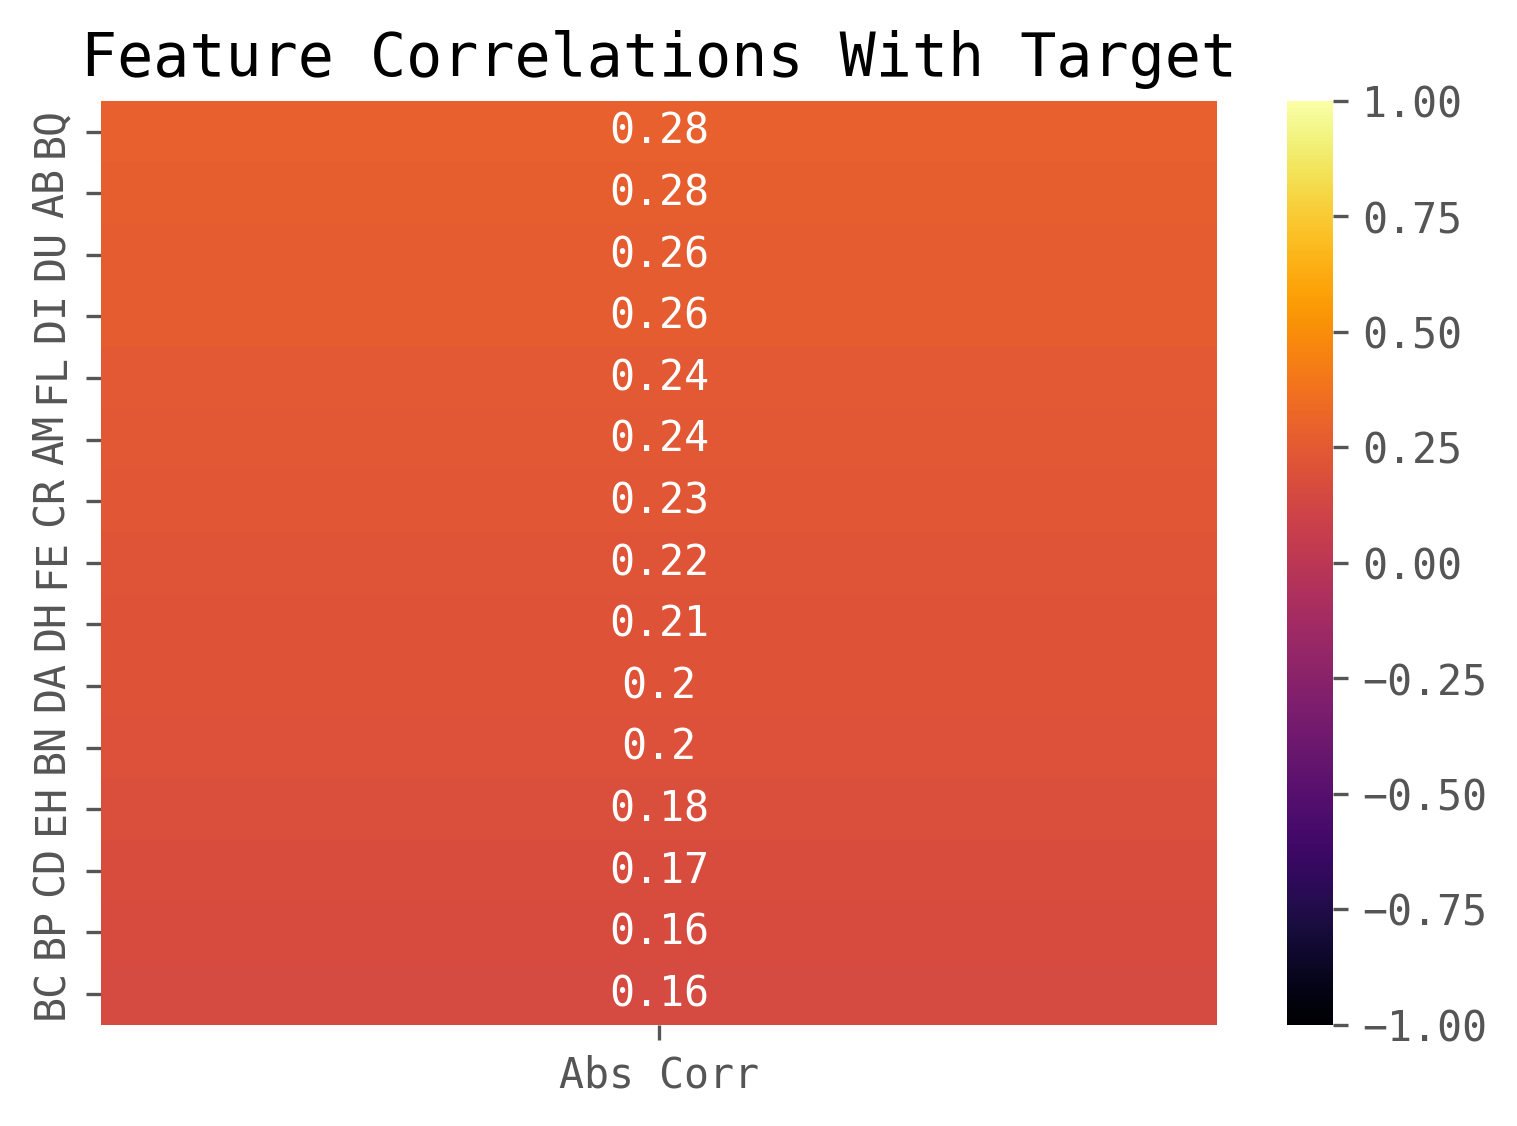

In [ ]:
correlations = train.loc[:,num_cols].corrwith(train['Class']).to_frame()  # 행열간의 상관계수를 반환하는 매서드 corrwith
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(sorted_correlations.iloc[1:].to_frame()[sorted_correlations>=.15], cmap='inferno', annot=True, vmin=-1, vmax=1, ax=ax)
plt.title('Feature Correlations With Target')
plt.show()

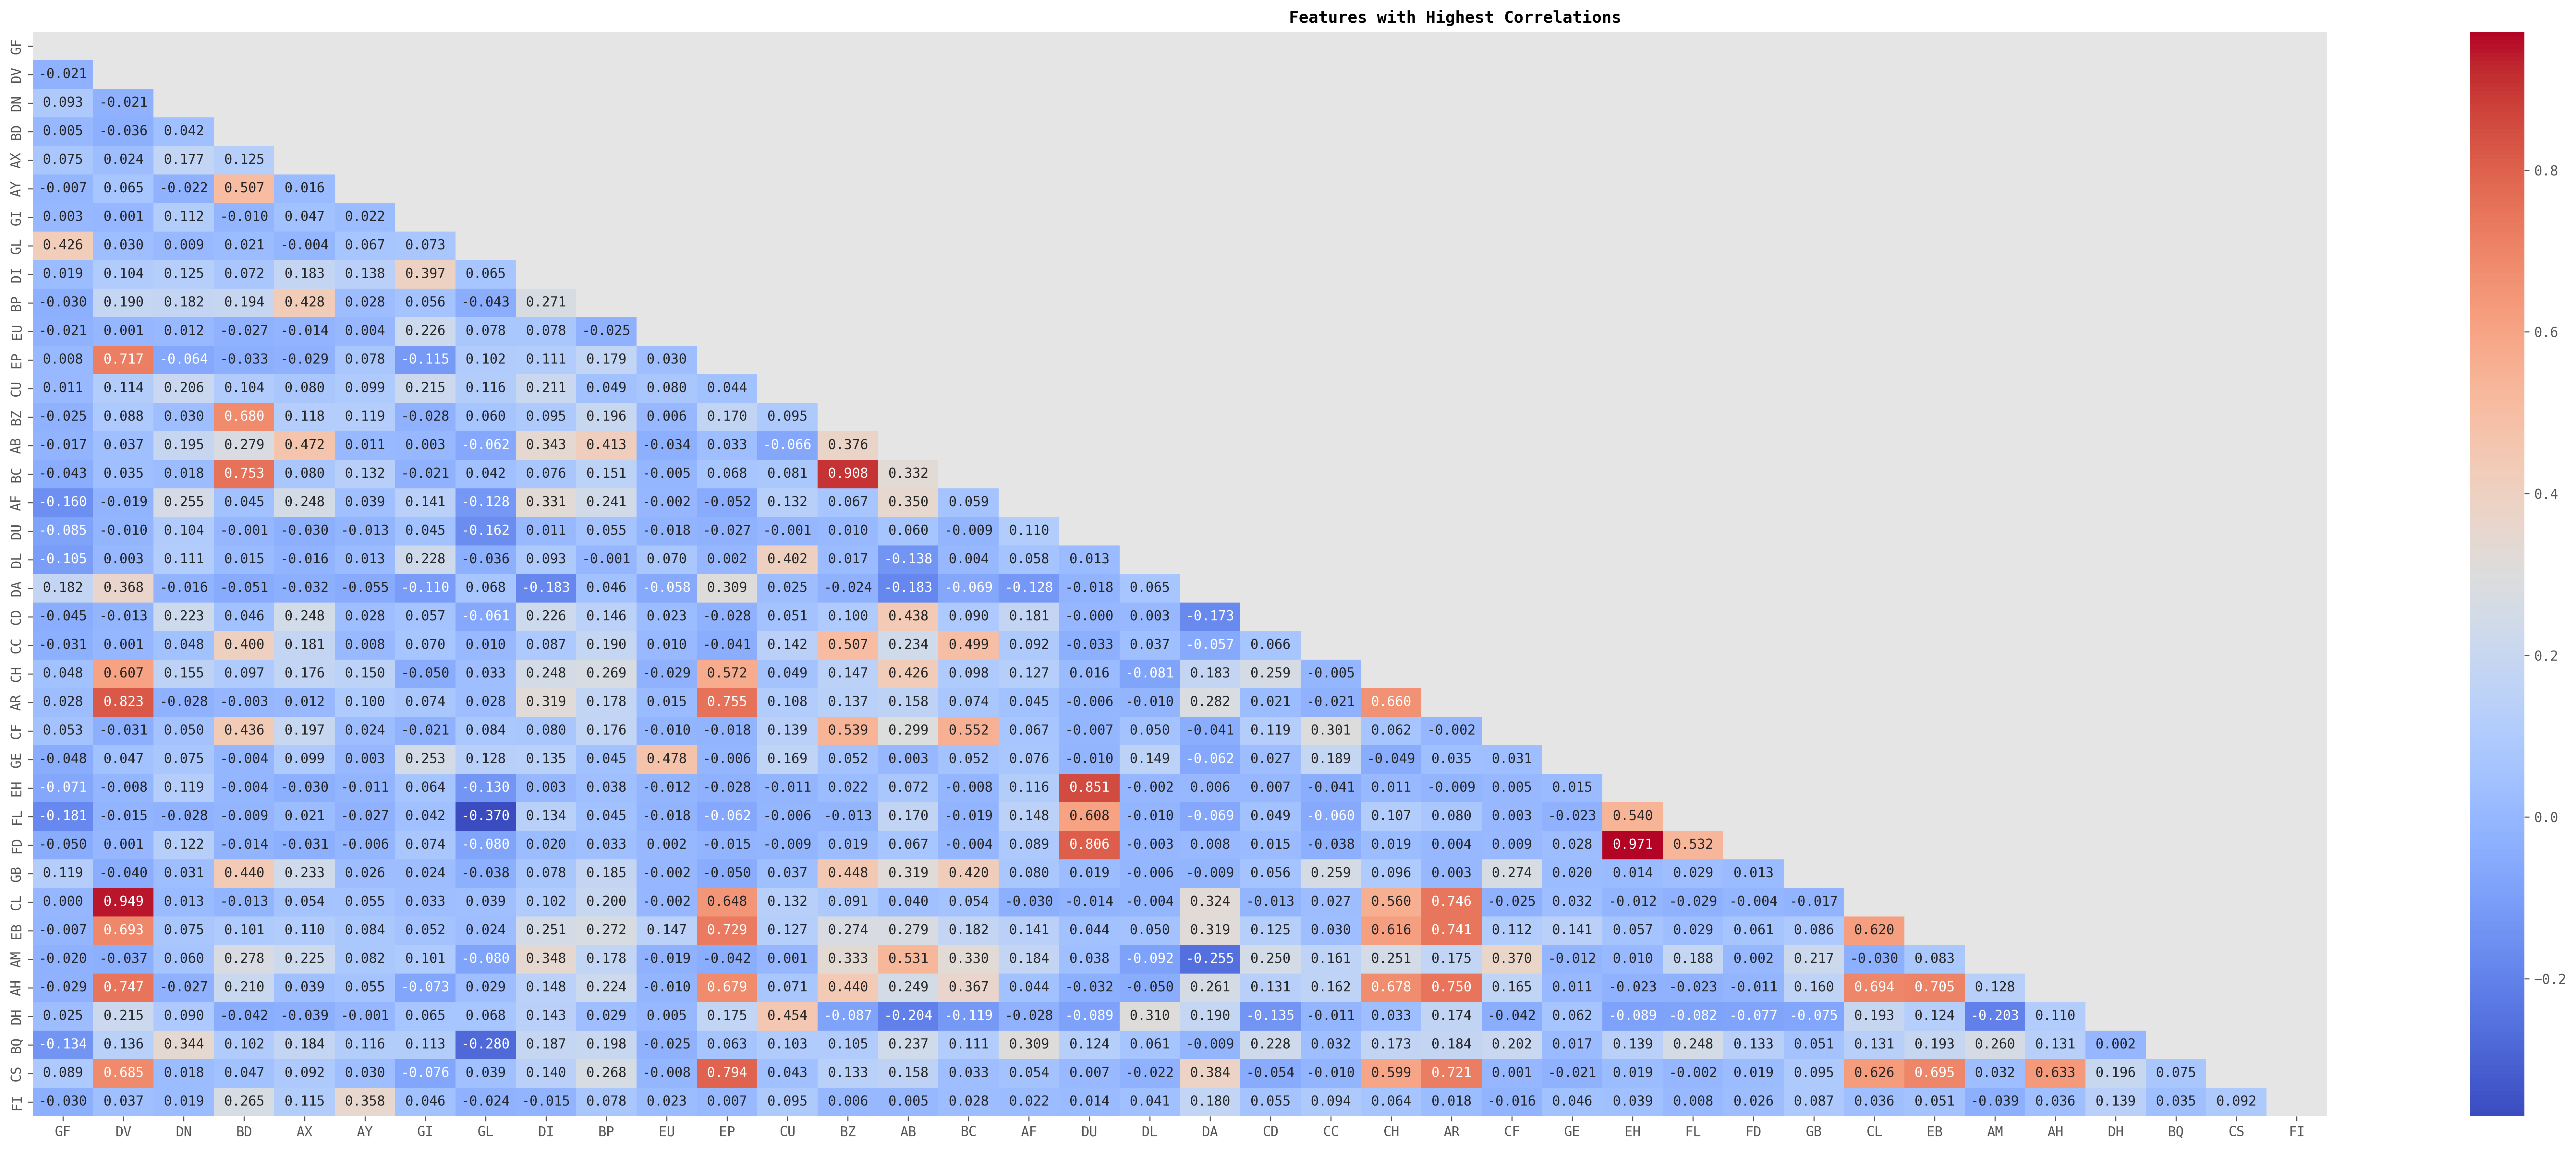

In [ ]:
correlations = train.loc[:,num_cols].corr().abs().unstack().sort_values(kind="quicksort",ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']] #preventing 1.0 corr
corr_max=correlations.level_0.head(150).tolist()
corr_max=list(set(corr_max)) #removing duplicates

corr_min=correlations.level_0.tail(34).tolist()
corr_min=list(set(corr_min)) #removing duplicates


correlation_train = train.loc[:,corr_max].corr()
mask = np.triu(correlation_train.corr())

plt.figure(figsize=(30, 12))
sns.heatmap(correlation_train,
            mask=mask,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            linewidths=0.00,
            cbar=True)


plt.suptitle('Features with Highest Correlations',  weight='bold')
plt.tight_layout()

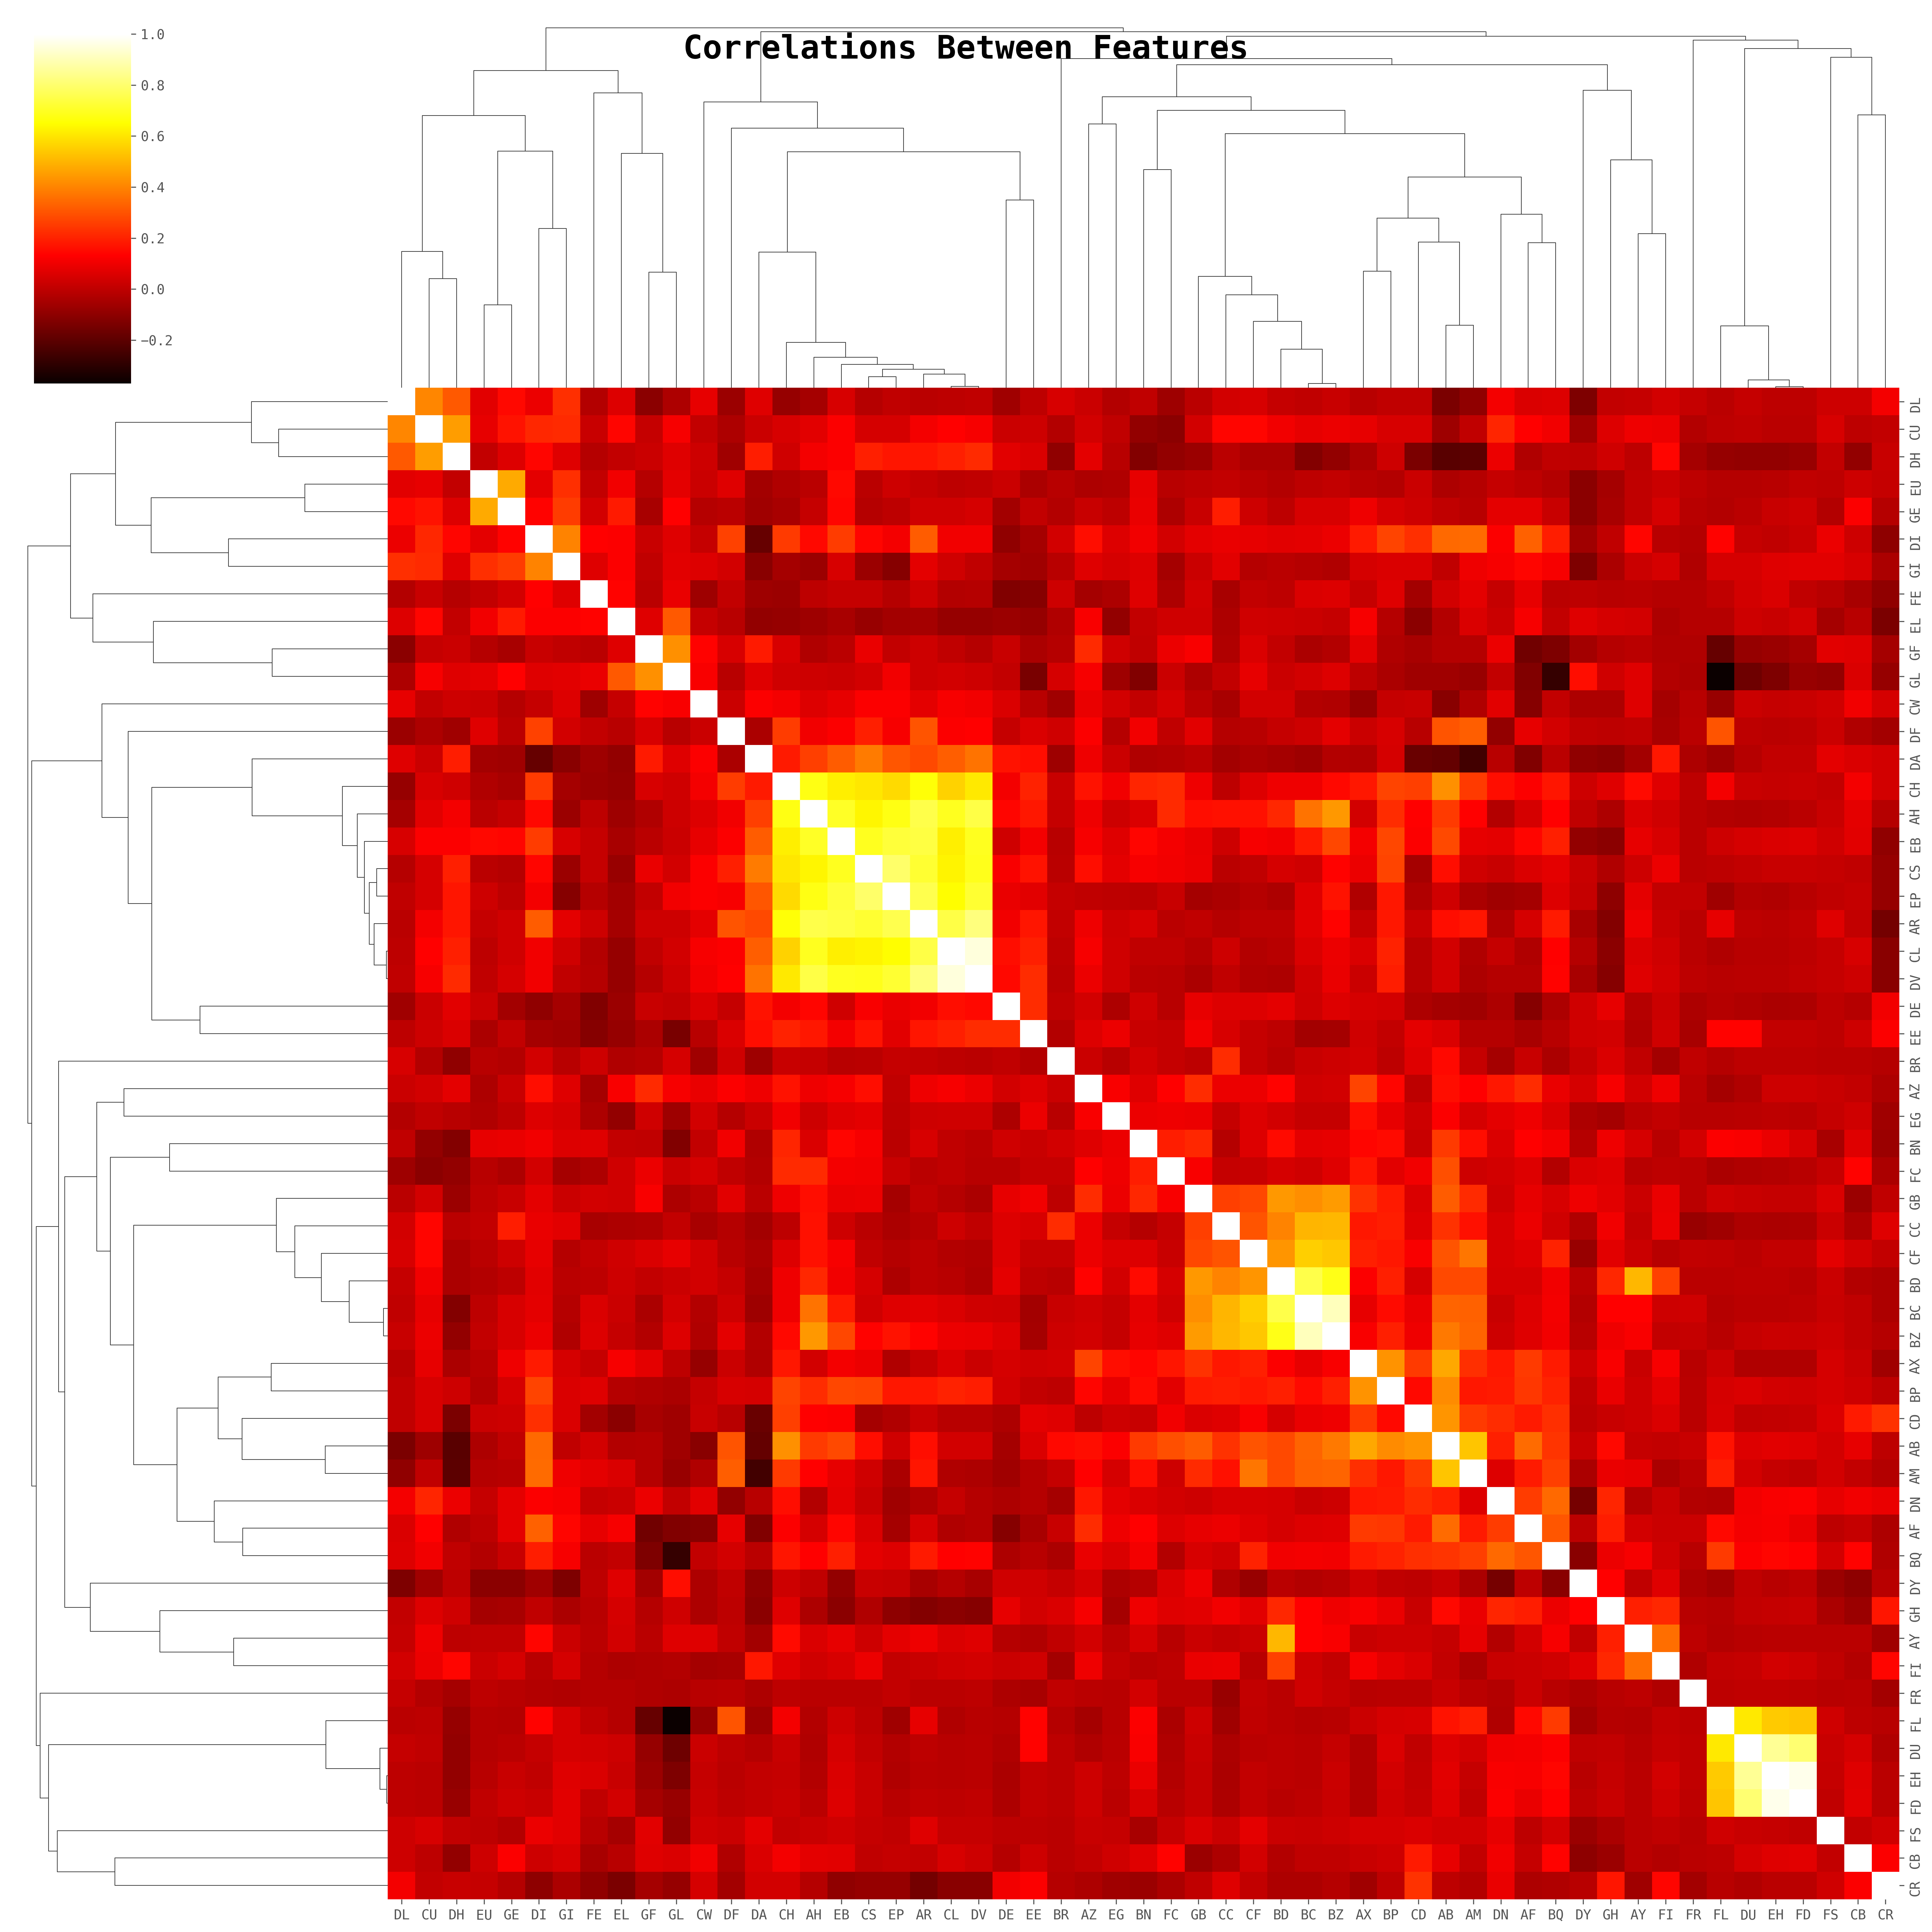

In [ ]:
corr = train.loc[:, num_cols].corr()
sns.clustermap(corr, metric="correlation", cmap="hot", figsize=(20, 20))
plt.suptitle('Correlations Between Features', fontsize=24, weight='bold')
plt.show()

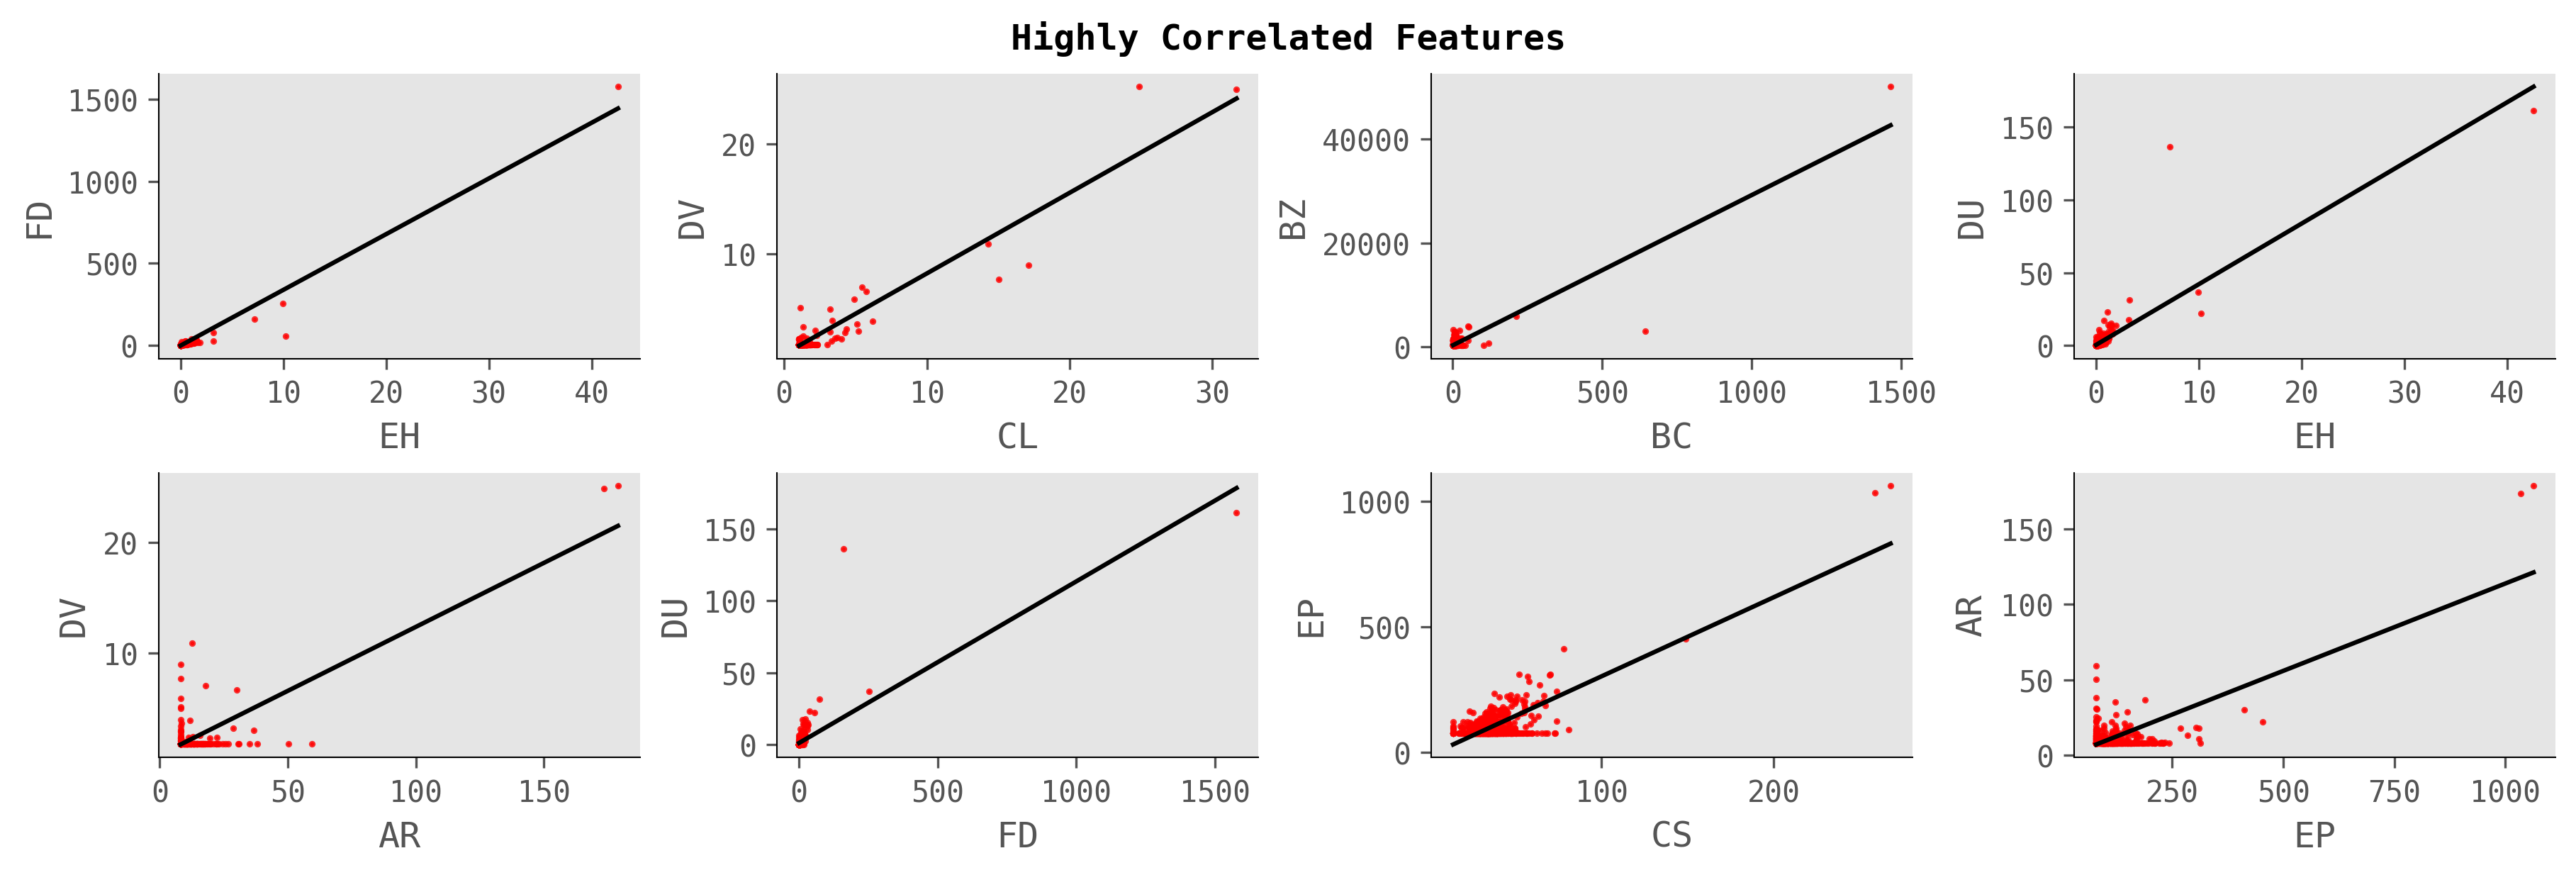

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), constrained_layout=True)
axes = axes.flatten()

# for i, j in zip(cols, axes):
i = 0
for row in range(0,16,2):
    a = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][0]
    b = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][1]

    sns.regplot(train, x=a, y=b, ci=False, ax=axes[i], order=1, scatter_kws={'color':'red', 's':1.5}, line_kws={'color':'black', 'linewidth':1.5})
    i+=1

plt.suptitle('Highly Correlated Features',  weight='bold')
plt.show()

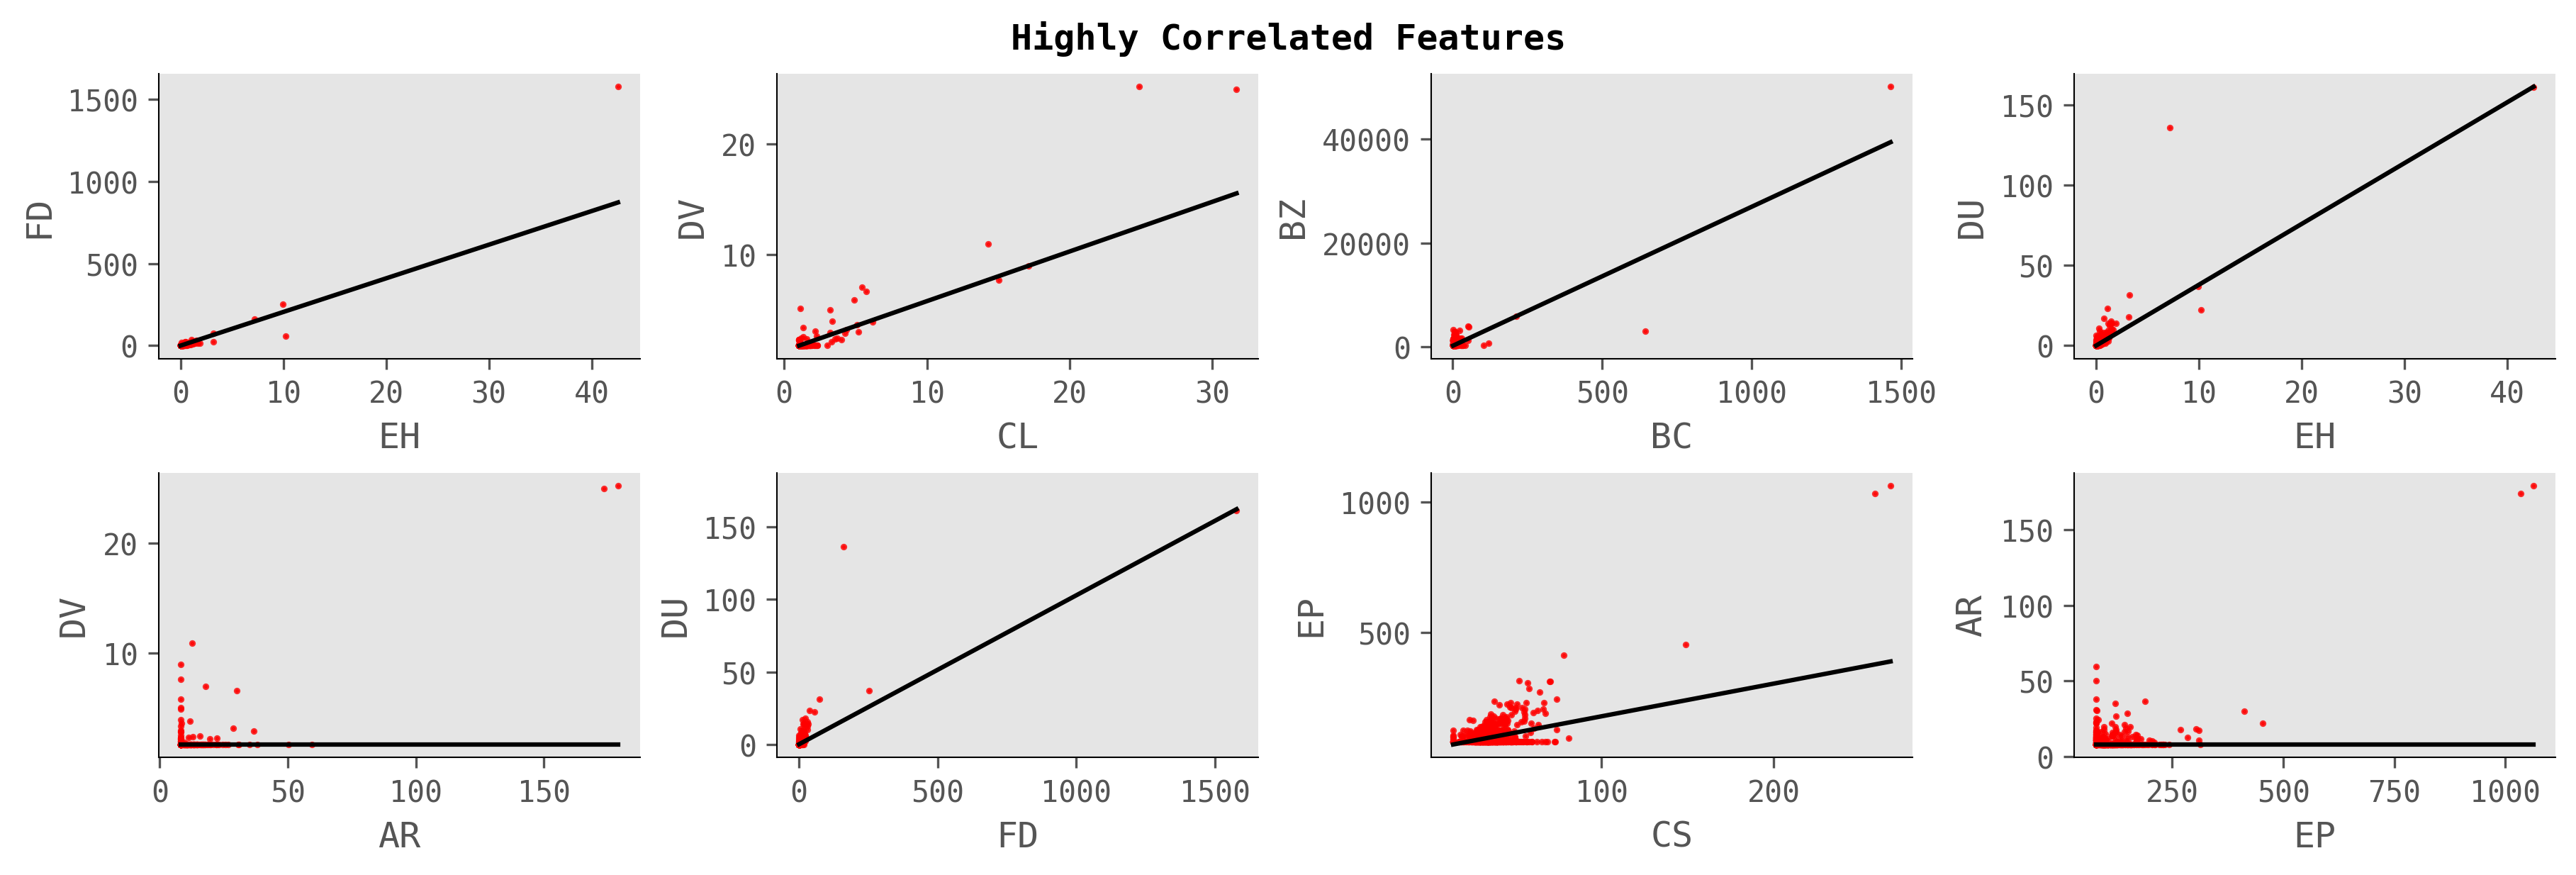

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), constrained_layout=True)
axes = axes.flatten()

# for i, j in zip(cols, axes):
i = 0
for row in range(0,16,2):
    a = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][0]
    b = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][1]


    sns.regplot(train, x=a, y=b, ci=False, ax=axes[i], robust=True, scatter_kws={'color':'red', 's':1.5}, line_kws={'color':'black', 'linewidth':1.5})
    i+=1

plt.suptitle('Highly Correlated Features',  weight='bold')
plt.show()

In [ ]:
# Create a LabelEncoder object.
encoder = LabelEncoder()
# Transform the data.
train[cat_cols] = encoder.fit_transform(train[cat_cols])
test[cat_cols] = encoder.transform(test[cat_cols])

In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [ ]:
oof = np.zeros((len(train), 2))

mskf = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=0)

final_preds = []

params={
    'iterations':10000,
    'learning_rate':0.005,
    'early_stopping_rounds':1000,
    'auto_class_weights':'Balanced',
    'loss_function':'MultiClass',
    'eval_metric':'MultiClass:use_weights=True',
    'random_seed':42,
    'use_best_model':True,
    'l2_leaf_reg':1,
    'max_ctr_complexity':15,
    'max_depth':10,
    "grow_policy":'Lossguide',
    'max_leaves':64,
    "min_data_in_leaf":40,

    }

for train_index,val_index in mskf.split(train, greeks.iloc[:,1:-1]):

    X_train, X_val = train.loc[train_index, num_cols + [cat_cols]], train.loc[val_index, num_cols + [cat_cols]]
    y_train, y_val = train.loc[train_index, 'Class'], train.loc[val_index, 'Class']


    model = cb.CatBoostClassifier(**params)
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)], verbose=1000)
    preds = model.predict_proba(X_val)
    oof[val_index, :] = preds
    final_preds.append(model.predict_proba(test.iloc[:,1:]))

TypeError: ignored

In [ ]:
def balance_logloss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)

    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2

    return logloss

balance_logloss(train['Class'], oof)

In [ ]:
from sklearn.metrics import log_loss

def balance_loglossv2(y_true, y_pred):
    target_mean = y_true.mean()
    w0 = 1/(1-target_mean)
    w1 = 1/target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y_true]
    loss = log_loss(y_true, y_pred, sample_weight=sample_weight)

    return loss

print(balance_loglossv2(train['Class'], oof))